# 1) Imports & Utilities

In [2]:
import os
import urllib.request
import zipfile
import io
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import joblib

import xgboost as xgb
import shap

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm

## Reproducibility

In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## Simple evaluation helper

In [4]:
def evaluate(y_true, y_pred, name=None):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    if name:
        print(f"{name} — MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return {"mae": mae, "rmse": rmse, "r2": r2}

# 2) Load Dataset (UCI)

In [5]:
# Read with pandas (xls)
df = pd.read_csv('/kaggle/input/concrete-compressive-strength-data-set/concrete_data.csv')
print('Dataset shape:', df.shape)
df.columns = [c.strip() for c in df.columns]
print(df.columns.tolist())

df.head()

Dataset shape: (1030, 9)
['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_compressive_strength']


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


# 3) Basic EDA

                                count        mean         std     min  \
cement                         1030.0  281.167864  104.506364  102.00   
blast_furnace_slag             1030.0   73.895825   86.279342    0.00   
fly_ash                        1030.0   54.188350   63.997004    0.00   
water                          1030.0  181.567282   21.354219  121.80   
superplasticizer               1030.0    6.204660    5.973841    0.00   
coarse_aggregate               1030.0  972.918932   77.753954  801.00   
fine_aggregate                 1030.0  773.580485   80.175980  594.00   
age                            1030.0   45.662136   63.169912    1.00   
concrete_compressive_strength  1030.0   35.817961   16.705742    2.33   

                                   25%      50%       75%     max  
cement                         192.375  272.900   350.000   540.0  
blast_furnace_slag               0.000   22.000   142.950   359.4  
fly_ash                          0.000    0.000   118.300   200.1

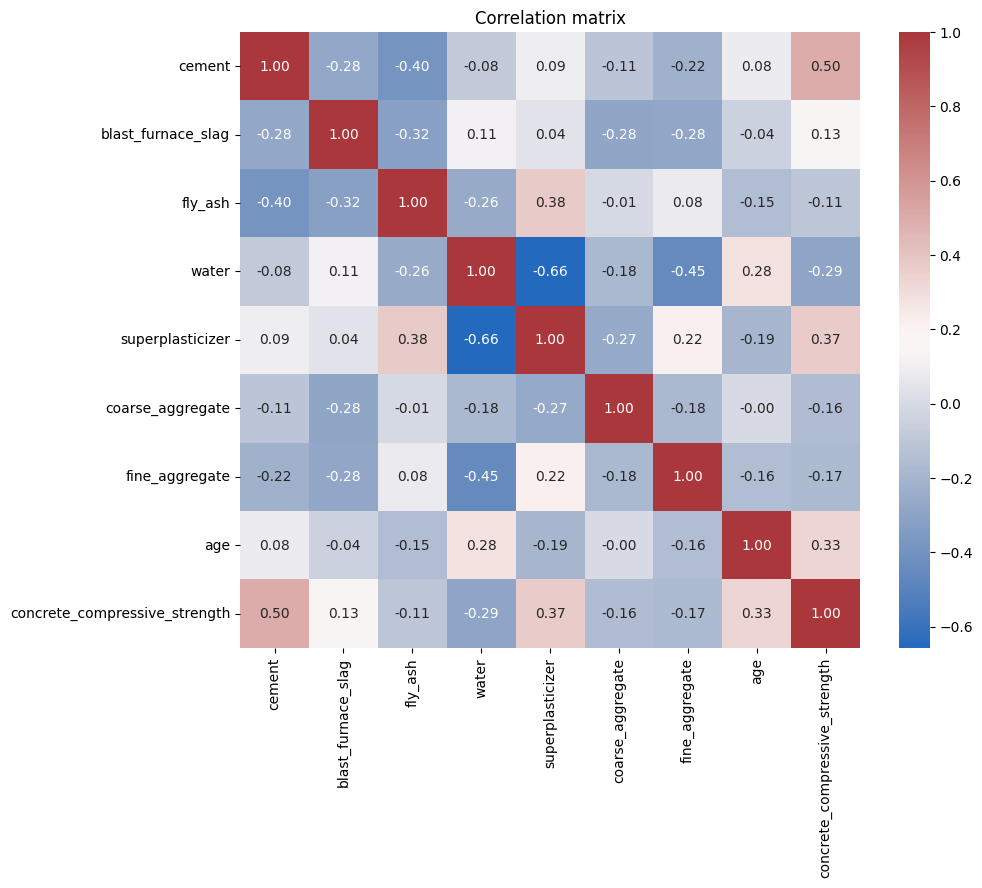

In [6]:
print(df.describe().T)

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='vlag')
plt.title('Correlation matrix')
plt.show()

# 4) Feature Engineering

In [19]:
work = df.copy()

### The dataset’s original column names from UCI are quite long — let’s check them first

In [20]:
print("Columns before renaming:")
print(work.columns.tolist())

Columns before renaming:
['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_compressive_strength']


### Add domain-aware features: water/cement ratio, total binder, binder ratios, aggregate ratio

In [32]:
work.rename(columns={
    'blast_furnace_slag': 'slag',
    'fly_ash': 'flyash',
    'coarse_aggregate': 'coarseagg',
    'fine_aggregate': 'fineagg',
    'concrete_compressive_strength': 'strength'
}, inplace=True)

### create features

In [33]:
work['binder_total'] = work['cement'] + work['slag'] + work['flyash']

### avoid division by zero

In [34]:
work['water_cement'] = work['water'] / (work['cement'] + 1e-8)
work['cement_ratio'] = work['cement'] / (work['binder_total'] + 1e-8)
work['slag_ratio'] = work['slag'] / (work['binder_total'] + 1e-8)
work['flyash_ratio'] = work['flyash'] / (work['binder_total'] + 1e-8)
work['aggregate_ratio'] = (work['coarseagg'] + work['fineagg']) / (work['binder_total'] + 1e-8)

### check new features

In [35]:
work[['binder_total','water_cement','cement_ratio','aggregate_ratio']].describe().T

,count,mean,std,min,25%,50%,75%,max
binder_total,1030.0,409.252039,92.780669,200.000000,336.425000,391.300000,483.700000,640.000000
water_cement,1030.0,0.748266,0.314005,0.266893,0.533333,0.675349,0.935165,1.882353
cement_ratio,1030.0,0.690276,0.209400,0.264000,0.548591,0.679131,0.812386,1.000000
aggregate_ratio,1030.0,4.534819,1.240297,2.376562,3.434167,4.470781,5.390386,9.850000


# 5) Prepare Data for Modeling

In [37]:
FEATURES = [
    'cement','slag','flyash','water','superplasticizer','coarseagg','fineagg','age',
    'binder_total','water_cement','cement_ratio','slag_ratio','flyash_ratio','aggregate_ratio'
]
TARGET = 'strength'

X = work[FEATURES].copy()
y = work[TARGET].copy()

### Train/test split (80/20)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (824, 14) Test shape: (206, 14)


### Scale features

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Save scaler for deployment

In [40]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

# 6) Random Forest (with GridSearchCV)

In [41]:
rf = RandomForestRegressor(random_state=SEED)
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf_gs = GridSearchCV(rf, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
rf_gs.fit(X_train_scaled, y_train)
print('RF best params:', rf_gs.best_params_)
rf_best = rf_gs.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
RF best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 400}


### Evaluate RF

In [42]:
rf_pred = rf_best.predict(X_test_scaled)
evaluate(y_test, rf_pred, 'Random Forest')

Random Forest — MAE: 3.5041, RMSE: 5.2940, R2: 0.8912


{'mae': 3.5041357865233573,
 'rmse': 5.2940374563837995,
 'r2': 0.8912326514224359}

# 7) XGBoost

In [43]:
xgb_model = xgb.XGBRegressor(random_state=SEED, n_estimators=500, learning_rate=0.05, max_depth=6, verbosity=0)
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], early_stopping_rounds=30, verbose=False)

xgb_pred = xgb_model.predict(X_test_scaled)
evaluate(y_test, xgb_pred, 'XGBoost')

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBoost — MAE: 3.0818, RMSE: 4.9031, R2: 0.9067


{'mae': 3.081812627570143, 'rmse': 4.9031207281408635, 'r2': 0.906702566661519}

# 8) PyTorch Neural Network 
# (simple wrapper for sklearn compatibility)

In [66]:
class TorchRegressor:
    """Enhanced PyTorch feedforward regressor for better performance."""
    def __init__(self, input_dim, hidden_dims=(128, 64), lr=1e-3, batch_size=32, epochs=300,
                 weight_decay=1e-5, dropout=0.2, device=None):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        self._build_model()

    def _build_model(self):
        layers = []
        in_dim = self.input_dim
        for h in self.hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.BatchNorm1d(h))        # Batch Normalization
            layers.append(nn.LeakyReLU(0.01))       # Leaky ReLU
            layers.append(nn.Dropout(self.dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))          # Output layer
        self.model = nn.Sequential(*layers).to(self.device)

    def fit(self, X, y, X_val=None, y_val=None, verbose=False):
        X_t = torch.tensor(X.astype(np.float32)).to(self.device)
        y_t = torch.tensor(y.astype(np.float32)).view(-1,1).to(self.device)
        dataset = TensorDataset(X_t, y_t)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        loss_fn = nn.MSELoss()
        scheduler = None
        if X_val is not None and y_val is not None:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=verbose)

        best_val_loss = np.inf
        patience = 30
        wait = 0

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for xb, yb in loader:
                optimizer.zero_grad()
                preds = self.model(xb)
                loss = loss_fn(preds, yb)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * xb.size(0)
            train_loss = running_loss / len(loader.dataset)

            # Validation
            if X_val is not None and y_val is not None:
                self.model.eval()
                with torch.no_grad():
                    Xv = torch.tensor(X_val.astype(np.float32)).to(self.device)
                    yv = torch.tensor(y_val.astype(np.float32)).view(-1,1).to(self.device)
                    val_preds = self.model(Xv)
                    val_loss = loss_fn(val_preds, yv).item()

                if verbose and (epoch % 20 == 0):
                    print(f"Epoch {epoch+1}/{self.epochs} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

                # Update learning rate
                if scheduler:
                    scheduler.step(val_loss)

                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    wait = 0
                    self.best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print("Early stopping")
                        break
            else:
                if verbose and (epoch % 50 == 0):
                    print(f"Epoch {epoch+1}/{self.epochs} — train_loss: {train_loss:.4f}")

        # Load best weights
        if hasattr(self, 'best_state'):
            self.model.load_state_dict(self.best_state)

    def predict(self, X):
        self.model.eval()
        X_t = torch.tensor(X.astype(np.float32)).to(self.device)
        with torch.no_grad():
            preds = self.model(X_t).cpu().numpy().ravel()
        return preds

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self._build_model()
        self.model.load_state_dict(torch.load(path, map_location=self.device))

### Instantiate and train

In [68]:
input_dim = X_train_scaled.shape[1]
tr_model = TorchRegressor(input_dim=input_dim, hidden_dims=(128,64), lr=1e-3, epochs=300, batch_size=32)
tr_model.fit(X_train_scaled, y_train.values, X_val=X_test_scaled, y_val=y_test.values, verbose=True)


The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


Epoch 1/300 — train_loss: 1540.6428, val_loss: 1480.4392
Epoch 21/300 — train_loss: 98.2993, val_loss: 61.0528
Epoch 41/300 — train_loss: 61.3797, val_loss: 39.8863
Epoch 61/300 — train_loss: 47.6482, val_loss: 33.9290
Epoch 81/300 — train_loss: 45.6596, val_loss: 33.2278
Epoch 101/300 — train_loss: 43.4186, val_loss: 31.0296
Early stopping


### Evaluate

In [69]:
nn_pred = tr_model.predict(X_test_scaled)
evaluate(y_test, nn_pred, 'PyTorch NN')

PyTorch NN — MAE: 4.1803, RMSE: 5.4593, R2: 0.8843


{'mae': 4.180298305252223, 'rmse': 5.459255123634005, 'r2': 0.8843378387551242}

### Save torch model

In [70]:
tr_model.save('torch_nn.pth')

# 9) Ensemble: Simple Averaging

In [71]:
ensemble_avg = (rf_pred + xgb_pred + nn_pred) / 3.0
evaluate(y_test, ensemble_avg, 'Ensemble (Averaging)')

Ensemble (Averaging) — MAE: 3.3636, RMSE: 4.8092, R2: 0.9102


{'mae': 3.3635762191937904, 'rmse': 4.80921210138588, 'r2': 0.9102421616293253}

# 10) Ensemble: Stacking 
## (use RF and XGB directly; wrap NN via wrapper that calls predict)

### Create lightweight sklearn-compatible estimators for stacking

In [72]:
class SklearnTorchWrapper:
    def __init__(self, torch_regressor):
        self.torch = torch_regressor
    def fit(self, X, y):
        # train a fresh copy on provided X,y (to avoid leakage)
        # We'll create a new instance with same hyperparams
        self._internal = TorchRegressor(input_dim=X.shape[1], hidden_dims=self.torch.hidden_dims, lr=self.torch.lr, epochs=100, batch_size=self.torch.batch_size)
        self._internal.fit(X, y, verbose=False)
        return self
    def predict(self, X):
        return self._internal.predict(X)

### Build stacking regressor

In [73]:
estimators = [
    ('rf', rf_best),
    ('xgb', xgb_model),
]

stack = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stack.fit(X_train_scaled, y_train)
stack_pred = stack.predict(X_test_scaled)
evaluate(y_test, stack_pred, 'Stacking (RF + XGB)')

Stacking (RF + XGB) — MAE: 3.1171, RMSE: 4.9660, R2: 0.9043


{'mae': 3.117094866127764, 'rmse': 4.966046285819026, 'r2': 0.9042924831353771}

# 11) Feature Importance & SHAP (use XGBoost for clarity)

In [74]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled)

### Summary plot (bar)

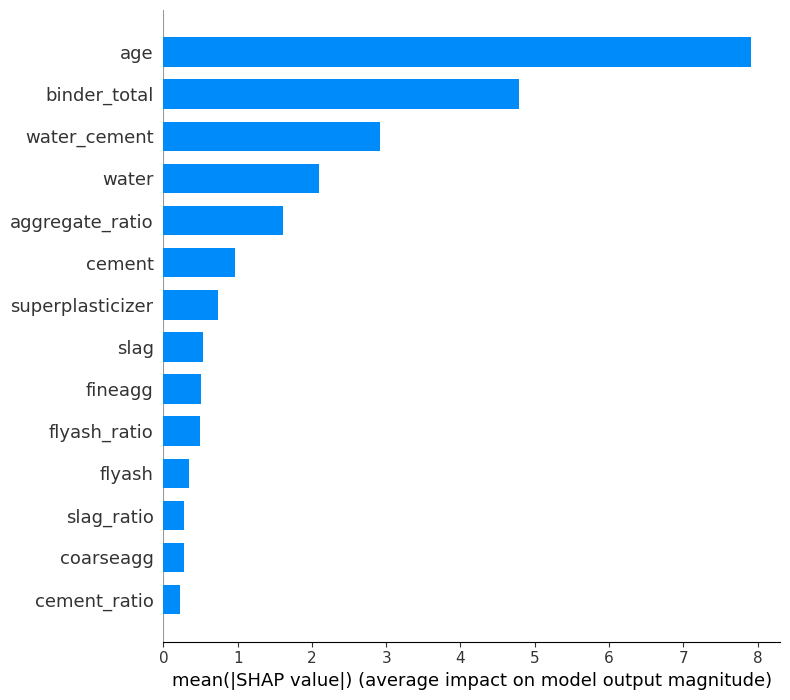

In [75]:
shap.summary_plot(shap_values, features=X_test, feature_names=FEATURES, plot_type='bar')

### Dependence plot for water_cement

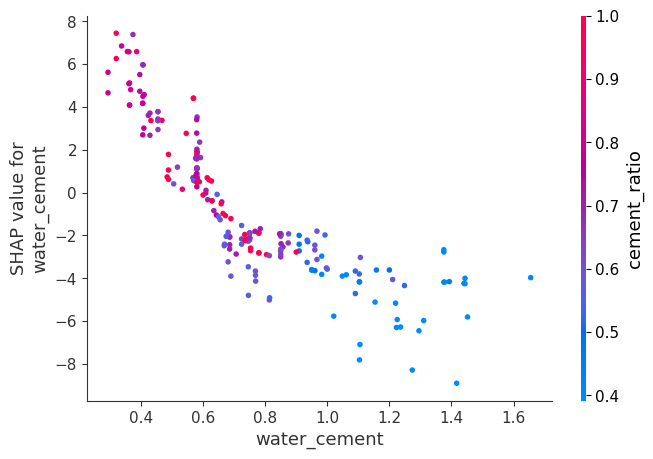

In [76]:
if 'water_cement' in FEATURES:
    shap.dependence_plot(FEATURES.index('water_cement'), shap_values.values, X_test, feature_names=FEATURES)

# 12) Save models and results

In [77]:
joblib.dump(rf_best, 'rf_best.joblib')
joblib.dump(xgb_model, 'xgb_model.joblib')
joblib.dump(stack, 'stack_model.joblib')

['stack_model.joblib']

### Save test predictions for reporting

In [78]:
results = pd.DataFrame({
    'y_true': y_test.values,
    'rf_pred': rf_pred,
    'xgb_pred': xgb_pred,
    'nn_pred': nn_pred,
    'ensemble_avg': ensemble_avg,
    'stack_pred': stack_pred
}, index=y_test.index)
results.to_csv('predictions.csv', index=False)

print('Saved models and predictions to working directory.')

Saved models and predictions to working directory.


# 13) Visualization: Compare model performance visually

In [81]:
perf = {
    'RandomForest': evaluate(y_test, rf_pred)['r2'],
    'XGBoost': evaluate(y_test, xgb_pred)['r2'],
    'PyTorchNN': evaluate(y_test, nn_pred)['r2'],
    'EnsembleAvg': evaluate(y_test, ensemble_avg)['r2'],
    'Stacking': evaluate(y_test, stack_pred)['r2']
}

perf_df = pd.DataFrame.from_dict(perf, orient='index', columns=['R2']).sort_values('R2', ascending=False)
print(perf_df)

                    R2
EnsembleAvg   0.910242
XGBoost       0.906703
Stacking      0.904292
RandomForest  0.891233
PyTorchNN     0.884338


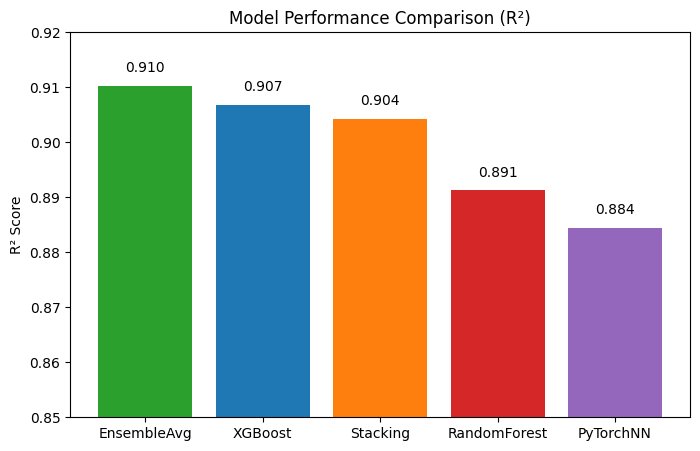

In [80]:
# Model names and scores
models = ['EnsembleAvg', 'XGBoost', 'Stacking', 'RandomForest', 'PyTorchNN']
r2_scores = [0.910242, 0.906703, 0.904292, 0.891233, 0.884338]

plt.figure(figsize=(8,5))
bars = plt.bar(models, r2_scores, color=['#2ca02c','#1f77b4','#ff7f0e','#d62728','#9467bd'])
plt.ylim(0.85, 0.92)
plt.ylabel('R² Score')
plt.title('Model Performance Comparison (R²)')

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.002, f'{yval:.3f}', ha='center', va='bottom')

plt.show()


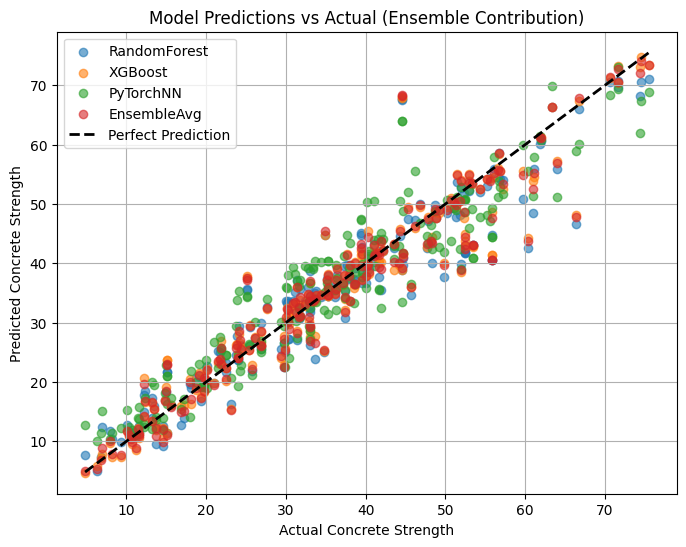

In [86]:
# y_true: actual concrete strength
# preds_dict: dictionary of model predictions
preds_dict = {
    'RandomForest': rf_pred,    # replace with your RF predictions
    'XGBoost': xgb_pred,        # replace with your XGBoost predictions
    'PyTorchNN': nn_pred,       # replace with your PyTorch NN predictions
    'EnsembleAvg': stack_pred  # replace with your ensemble predictions
}

plt.figure(figsize=(8,6))

# Plot each model
for name, preds in preds_dict.items():
    plt.scatter(y_true, preds, alpha=0.6, label=name)

# Perfect prediction line
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Concrete Strength')
plt.ylabel('Predicted Concrete Strength')
plt.title('Model Predictions vs Actual (Ensemble Contribution)')
plt.legend()
plt.grid(True)
plt.show()
